In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dynamic_hedging_sims import SimulateStrat
import seaborn as sns

# Dynamic Hedging

The purpose is to demonstrate how our dynamic hedging strategy works. <br>
We'll review the logic behind the strategy, how the strategy reacts given different conditions and simulate how the strategy would perform.

## How it Works

### Concept

The high-level concept is to generate returns via providing liquidity to AMMs, while hedging volatility risk. <br> 
The strategy uses lending protocols and AMMs. <br> 
The simplest form of the strategy uses a stablecoin and a volatile token. <br>
For simplicity we will use USDC as FTM and the sample tokens throughout this document, and we will assume we only provide liquidity to uniswapV2 style 50/50 pools. 

In simple terms, the strategy does the following: 
- Lend USDC
- Borrow ETH
- Provide liquidity to AMM

This is a very common strategy in DeFi. There are a number of protocols who offer delta-neutral vaults that borrow and provide liquidity using the borrowed funds. Most of these strategies rebalance positions using a paramater called 'Collateral Ratio'.<br>
Delta-neutral vaults work very well during ranging conditions. But when price has volatile movements in either direction, impermanent loss outweights the benefits and the strategy usually ends up unprofitable. 

For this reason, our strategy is designed with the flexibility of having long or short price exposure. We can think of delta-neutral as the "base" state of our strategy, and this state can be updated to have price exposure.

A good way to think about this is as a way of trading and (passively) market making at the same time.

### Strategy State and Math

The strategy consists of 3 different positions:
- The collateral lend (USDC)
- The debt borrow (FTM)
- The lp position (USDC-FTM)

The total value of the strategy is calculated as: <br>
> $ T = C - D + L $

> Where:
> - T: total value
> - C: collateral
> - D: debt
> - L: lp

#### Strategy Paramaters

As stated above, the strategy is design with flexibility in mind to allow a non-delta neutral state. <br>
This is acheived by adding a second parameter called 'Price Exposure'.

The strategy has 2 main user defined parameters:
- $ TCR $  (Target Collateral Ratio): ratio of the debt over collateral
- $ TE $  (Target Price Exposure): percentage of the total amount held in the strategy that has exposure to volatility 
> note: negative TE means short exposure.

Both parameters above are used to determine the target (or want) state the strategy aims to be at. <br>
At any moment in time, we can calculate the actual collateral ratio and price exposure of the strategy.
- Collateral ratio: $ CR=\frac{D}{C} $
- Price exposure: $ E=\frac{0.5*L-D}{T} $

#### Calculating the Want State

Assume we have $10000 of capital to invest (T = 10000) and we set TCR = 0.65 and TE = 0.
To get the want state, we have to solve the system of equations below.


$$
T=C-D+L\\
TCR=\frac{D}{C}\\
TE=\frac{0.5*L-D}{T}\\	
$$

Since we have the values of T, TCR and TE. We can get the values of C, D and L.

$$
C=\frac{T*(1-2*TE)}{1+TCR}\\
D=C*TCR\\
L=T-C+D\\	
$$

In [1]:
def want_state(t: float, tcr: float, te: float):
    c = t*(1 - 2*te)/(1 + tcr)
    d = c*tcr
    l = t - c + d
    return c, d, l

t = 10000
tcr = 0.65

# Example 1
c, d, l = want_state(t, tcr, 0)
print('TCR = 0.65 , TE = 0\n------------------')
print('Collateral: ${0:.2f}\nDebt: ${1:.2f}\nLP: ${2:.2f}\nTotal: ${3:.2f}'.format(c,d,l,c-d+l))

# Example 2
c, d, l = want_state(t, tcr, -0.1)
print('\n')
print('TCR = 0.65 , TE = -0.1\n------------------')
print('Collateral: ${0:.2f}\nDebt: ${1:.2f}\nLP: ${2:.2f}\nTotal: ${3:.2f}'.format(c,d,l,c-d+l))

TCR = 0.65 , TE = 0
------------------
Collateral: $6060.61
Debt: $3939.39
LP: $7878.79
Total: $10000.00


TCR = 0.65 , TE = -0.1
------------------
Collateral: $7272.73
Debt: $4727.27
LP: $7454.55
Total: $10000.00


#### Evolution of Individual Positions

Since the strategy holds 2 tokens (USDC and FTM), it is obvious that the value of the strategy will depend on the price of them. Since USDC is a stablecoin, for the sake of simplicity, we will assume its value will stay constant. This means that the value of the strategy depends on the price evolution of FTM as well as the interest rates of each position.

Below, we show how the value of each position changes.

> Where: 
> - $i_c$ : lending interest rate
> - $i_d$ : debt interest rate
> - $i_l$ : lp interest via fees and farm rewards
> - $\Delta P$ : price change in percentage terms

$$
C_{i+1}=C_i*(1+i_c)\\
D_{i+1}=D_i*(1+i_d)*(1+\Delta P)\\
L_{i+1}=L_i*(1+i_l)*(1+\Delta P)^{0.5}*1^{0.5}\\	
$$


In [5]:
# Update collateral
def update_collateral(c: float, r: float):
    return c*(1+r)

# Update debt
def update_debt(d: float, p_chg: float, r: float):
    return d*(1+p_chg)*(1+r)

# Update lp
def update_lp(l: float, p1_chg: float, r: float):
    return l*(1+r)*((1+p1_chg)**0.5)*(1**0.5)

# Assume we start with state
t = 10000
tcr = 0.65
c, d, l = want_state(t, tcr, 0)

# Given the price change below, the positions now have
    # Also note that we are assuming the change occurs in a 30-day timeframe (this applicable to interest rates)
p_chg = 0.05
c1 = update_collateral(c, 0.01/12)
d1 = update_debt(d, p_chg, 0.03/12)
l1 = update_lp(l, p_chg, 0.25/12)
t1 = c1-d1+l1
print('Price Change = 5% , TE = 0\n------------------')
print('Collateral: ${0:.2f}\nDebt: ${1:.2f}\nLP: ${2:.2f}\nTotal: ${3:.2f}'.format(c1,d1,l1,t1))
print('Return: {0:.3f}%'.format(100*(t1/t-1)))

# Assume we start with state
t = 10000
tcr = 0.65
c, d, l = want_state(t, tcr, 0.1)

# Given the price change below, the positions now have
p_chg = 0.02
c1 = update_collateral(c, 0.01/12)
d1 = update_debt(d, p_chg, 0.03/12)
l1 = update_lp(l, p_chg, 0.25/12)
t1 = c1-d1+l1
print('\n')
print('Price Change = 2% , TE = 0.1\n------------------')
print('Collateral: ${0:.2f}\nDebt: ${1:.2f}\nLP: ${2:.2f}\nTotal: ${3:.2f}'.format(c1,d1,l1,t1))
print('Return: {0:.3f}%'.format(100*(t1/t-1)))

Price Change = 5% , TE = 0
------------------
Collateral: $6065.66
Debt: $4146.70
LP: $8241.55
Total: $10160.50
Return: 1.605%


Price Change = 2% , TE = 0.1
------------------
Collateral: $4852.53
Debt: $3222.58
LP: $8560.35
Total: $10190.29
Return: 1.903%


### Rebalancing

As price changes, the state of our strategy changes as well. In simple terms, as price moves further away from the initial investment price, the collateral ratio and price exposure move further away from the targets defined.

In the example below we show how the CR and E change.

In [7]:
# Define a function to update all positions at the same time
def update_all(c: float, d: float, l:float, rc: float, rd: float, rl: float, p_chg: float):
    _c = update_collateral(c, rc)
    _d = update_debt(d, p_chg, rd)
    _l = update_lp(l, p_chg, rl)
    return _c, _d, _l

# Define a function to calculate the current state
def get_state(c: float, d: float, l: float):
    _cr = d/c
    _e = (l*0.5 - d)/(c-d+l)
    return _cr, _e

# Given the initial state, we can see that the state is the same as our target
c, d, l = want_state(10000, 0.65, 0)
cr, e = get_state(c, d, l)
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}'.format(cr, e))

# Now given a 5% price change
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, 0.05
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State with 5% Price Change and TE = 0\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}'.format(cr, e))

# This is even more visible with higher target exposure and price changes
c, d, l = want_state(10000, 0.65, -0.1)
cr, e = get_state(c, d, l)
print('\n')
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}'.format(cr, e))
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, -0.2
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State with -20% Price Change and TE = -0.1\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}'.format(cr, e))

Initial State
---------------
CR: 0.650
E: -0.000


New State with 5% Price Change and TE = 0
---------------
CR: 0.684
E: -0.003


Initial State
---------------
CR: 0.650
E: -0.100


New State with -20% Price Change and TE = -0.1
---------------
CR: 0.521
E: -0.038


In order to tackle this, we have to rebalance our positions periodically when specific conditions are met. <br>
We have 2 types of rebalancing operations:
- Collateral rebalance: modifies collateral and debt to bring collateral ratio back to its target value
- Exposure rebalance: modifies debt and lp to bring the exposure back to its target value

#### Collateral Ratio Rebalancing

The first step is to define thresholds for when rebalancing should be executed. <br>
If the collateral ratio of the strategy moves outside either of the thresholds we will rebalance it. <br>
For this, we will define 2 more parameters:
- Max CR: maximum collateral ratio allowed
- Min CR: minimum collateral ratio allowed
> note: the Max CR is the most important parameter here. Since this is also used to ensure that our short position is not liquidated.

There are many ways to perform this operation. Ideally we want to avoid swapping assets. Since our liquidity pool consists of a 50/50 split, we will rebalance by adding/removing the same amount from our collateral and debt positions.

In other words, given the current collateral value is $C_i$, debt value $D_i$ and lp value $L_i$. We want to solve the equation below.
> Where:
> - a: is the amount to add to our collateral position and to repay our debt

$$
TCR = \frac{D_i-a}{C_i+a} \Rightarrow a=\frac{D_i-C_i*TCR}{1+TCR}
$$

First, note that if $a$ is negative, it means that we need to remove collateral and borrow FTM. If $a$ is positive, then we need to add collateral and repay our debt. <br>
If $a$ is positive, we need to remove assets from the liquidity pool so we can add collateral and repay. In fact, we need to remove $2*a$. <br>
Hence, we need to update our state in the following manner:

$$
C_{i+1}=C_i+a\\
D_{i+1}=D_i-a\\
L_{i+1}=L_i-2*a\\	
$$

In [8]:
# Collateral rebalance
def cr_rebal(c: float, d: float, l: float, tcr: float):
    _a = (d-c*tcr)/(1+tcr)
    _c = c + _a
    _d = d - _a
    _l = l - 2*_a
    return _a, _c, _d, _l

# Given the initial state
c, d, l = want_state(10000, 0.65, 0)
cr, e = get_state(c, d, l)
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c-d+l))

# Now given a price change
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, 0.1
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c1-d1+l1))

# Now, if we rebalance collateral ratio we get
a, c2, d2, l2 = cr_rebal(c1, d1, l1, 0.65)
cr, e = get_state(c2, d2, l2)
print('\n')
print('Updated State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}\na: ${3:.2f}'.format(cr, e, c2-d2+l2, a))

Initial State
---------------
CR: 0.650
E: -0.000
Total: $10000.00


New State
---------------
CR: 0.716
E: -0.012
Total: $10156.99


Updated State
---------------
CR: 0.650
E: -0.012
Total: $10156.99
a: $243.33


As we can see above, the collateral ratio of the strategy is back to our target value. <br>
Also, note that the total value remains the same and that the exposure doesn't change. <br>
This makes sense, since we are removing $2*a$ from the liquidity pool and removing $a$ from our debt position. <br>
Looking at our exposure equation we can very clearly see that this operation has no impact to it.

$$
E=\frac{0.5*L-D}{T} \Rightarrow E=\frac{0.5*(L-2*a)-(D-a)}{T} \Rightarrow E=\frac{0.5*L-a-D+a))}{T} \Rightarrow E=\frac{0.5*L-D}{T}
$$

#### Exposure Rebalancing

Since our collateral rebalancing operation doesn't affect exposure, we need to create another operation. <br>
As before, we will define a threshold which represents boundaries that will trigger a rebalancing operation. <br>
In this case we will define only 1 parameter:
- E Treshold: the max absolute value allowed for the difference between the target and current exposure.

In this operation is not possible to avoid swapping assets. Hence, we have to account for trading fees as part of the operation. <br>

Given the current collateral value is $C_i$, debt value $D_i$ and lp value $L_i$. We want to solve the equation below.
> Where:
> - a: is the amount to remove from the lp and repay
> - swapfee: is the trading fee that the strategy will incur

$$
TE=\frac{0.5*(L_i-a)-(D_i-a)}{T_i} \Rightarrow a=2*(TE*T_i-0.5*L_i+D_i)
$$

Note that a positive $a$ means we remove from the lp and repay. A negative $a$ means we borrow and add to the lp. <br>
Hence, the new state should be updated in the following manner:

If $a > 0$ Then

$$
C_{i+1}=C_i\\
D_{i+1}=D_i-0.5*a*(2-swapfee)\\
L_{i+1}=L_i-a\\	
$$

If $a < 0$ Then

$$
C_{i+1}=C_i\\
D_{i+1}=D_i-a\\
L_{i+1}=L_i-0.5*a*(2-swapfee)\\	
$$

Note that depending on the sign of $a$ we charge swapfee either to the lp of debt. Also, note that we only charge the swapfee to 50% of the value of a. This is because we always need to swap 50% of $a$.

In [9]:
# Exposure rebalance
def exposure_rebal(c:float, d: float, l:float, te: float, swapfee: float=0.0025):
    t = c-d+l
    _a = 2*(te*t - 0.5*l + d)
    if _a > 0:
        _c = c
        _d = d - 0.5*_a*(2-swapfee)
        _l = l - _a
    elif a <= 0:
        _c = c
        _d = d - _a
        _l = l - 0.5*_a*(2-swapfee)   
    return _a, _c, _d, _l

# Given the initial state
c, d, l = want_state(10000, 0.65, 0)
cr, e = get_state(c, d, l)
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c-d+l))

# Now given a price change
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, 0.1
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c1-d1+l1))

# Now, if we rebalance collateral ratio we get
a, c2, d2, l2 =  exposure_rebal(c1, d1, l1, 0)
cr, e = get_state(c2, d2, l2)
print('\n')
print('Updated State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}\na: ${3:.2f}'.format(cr, e, c2-d2+l2, a))

Initial State
---------------
CR: 0.650
E: -0.000
Total: $10000.00


New State
---------------
CR: 0.716
E: -0.012
Total: $10156.99


Updated State
---------------
CR: 0.675
E: -0.000
Total: $10156.67
a: $252.84


Note that eventhough the exposure has come back to our target value, the collateral ratio of the strategy also changed. 
Again, this makes perfect sense when thinking about the collateral ratio equation. In our example, since $a$ is positive, we remove from the lp and repay debt. Hence, reducing the collateral ratio.<br>
Also, note the reduction in the total value held by the strategy due to trading fees.

$$
CR = \frac{D_i-a}{C_i}
$$

## Simulation Overview

In this section we will present a high-level review of how the strategy performs using FTM price action.

### FTM Chart

We will simulate how the strategy performs given different parameters. <br>
The dataset will be FTM hourly price action from 06-01-2022 to 03-31-2023.

Key points
- The dataset has a good amount of volatility with price doing multiple 50% drops and a >300% increase
- There is a period of low volatility range
- A period where price rallied significantly
- Multiple periods where price decrease by 50%

FTM max price: $0.649
FTM min price: $0.165
FTM avg price: $0.306


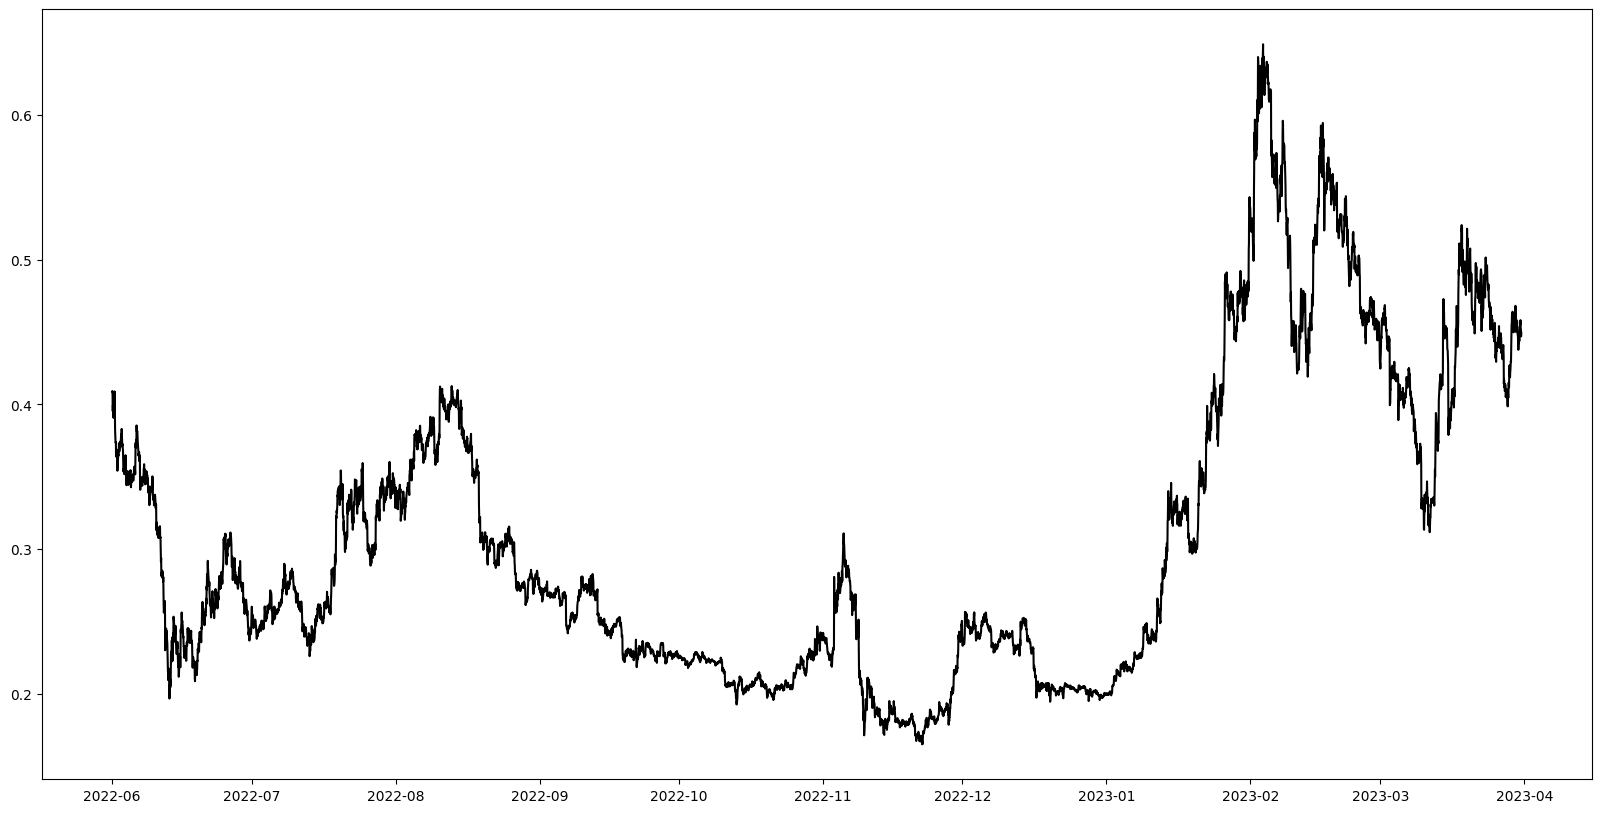

In [2]:
# Load data
data = pd.read_csv('ftm_1hr.csv')
data['time'] = pd.to_datetime(data['time'])

# Summary stats
print('FTM max price: ${:.3f}'.format(data['close'].max()))
print('FTM min price: ${:.3f}'.format(data['close'].min()))
print('FTM avg price: ${:.3f}'.format(data['close'].mean()))

# Plot data
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.plot(data['time'], data['close'], color = 'black')
plt.show()

### Simulations

The purpose here is to get a high-level understanding of how the strategy performs given different target exposures and exposure thresholds. <br>
We will start by defining the parameters that will remain constant in all simulations.
- Note that we set the lending rates to 1% and the borrow rate to 3% apr
- We assume the AMM apr is 25%
- we set 60 minutes per step since we are using the hourly dataset

We also want to do a quick review of how the rebalancing logic works.
- During every step, we first check if exposure needs to be rebalanced
    - abs(current exposure - target exposure) > exposure threshold
- we then check if the collateral ratio needs to be rebalanced
    - current collateral ratio > max collateral ratio or current collateral ratio < min collateral ratio
    
Note that we first rebalance exposure because this operations changes the collateral ratio, while the collateral rebalance operation doesn't change the exposure.

In [3]:
t = 100
tcr = 0.65
c_apr = 0.01
d_apr = 0.03
l_apr = 0.25
min_per_step = 60
pricefeed = data['close'].tolist()
min_cr = 0.45
max_cr = 0.7

#### Sim 1

Our first example is a delta-neutral strategy where we rebalance exposure if it has a difference greater than 5% from our target.

Notes:
- The strategy performs relatively well with a total return of 6.5%
- It has a max daily drawdown of 0.84% and a max weekly drawdown of 1.43%
- Collateral is rebalanced 33 times and exposure only 9 times

In [4]:
te = 0
e_thresh = 0.05
sim = SimulateStrat(t, tcr, te)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $106.56
Strategy Max: $106.57
Strategy Min: $98.65

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 6.562%
Total Return: $6.56235
Annualized Return: 7.898%
Max Daily Return: 0.454%
Min Daily Return: -0.840%
Max Weekly Return: 0.858%
Min Weekly Return: -1.432%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.73
Max Exposure: 0.05
Min Collateral Ratio: 0.44
Min Exposure: -0.05

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 33
Count of Exposure Rebalance: 9
Count of Both Rebalance: 3
Count of Exposure Update: 0


The plot below shows how the strategy changes in values through time. <br>
Also, note how each position ranges between with sharp changes which occur during rebalancing operations.

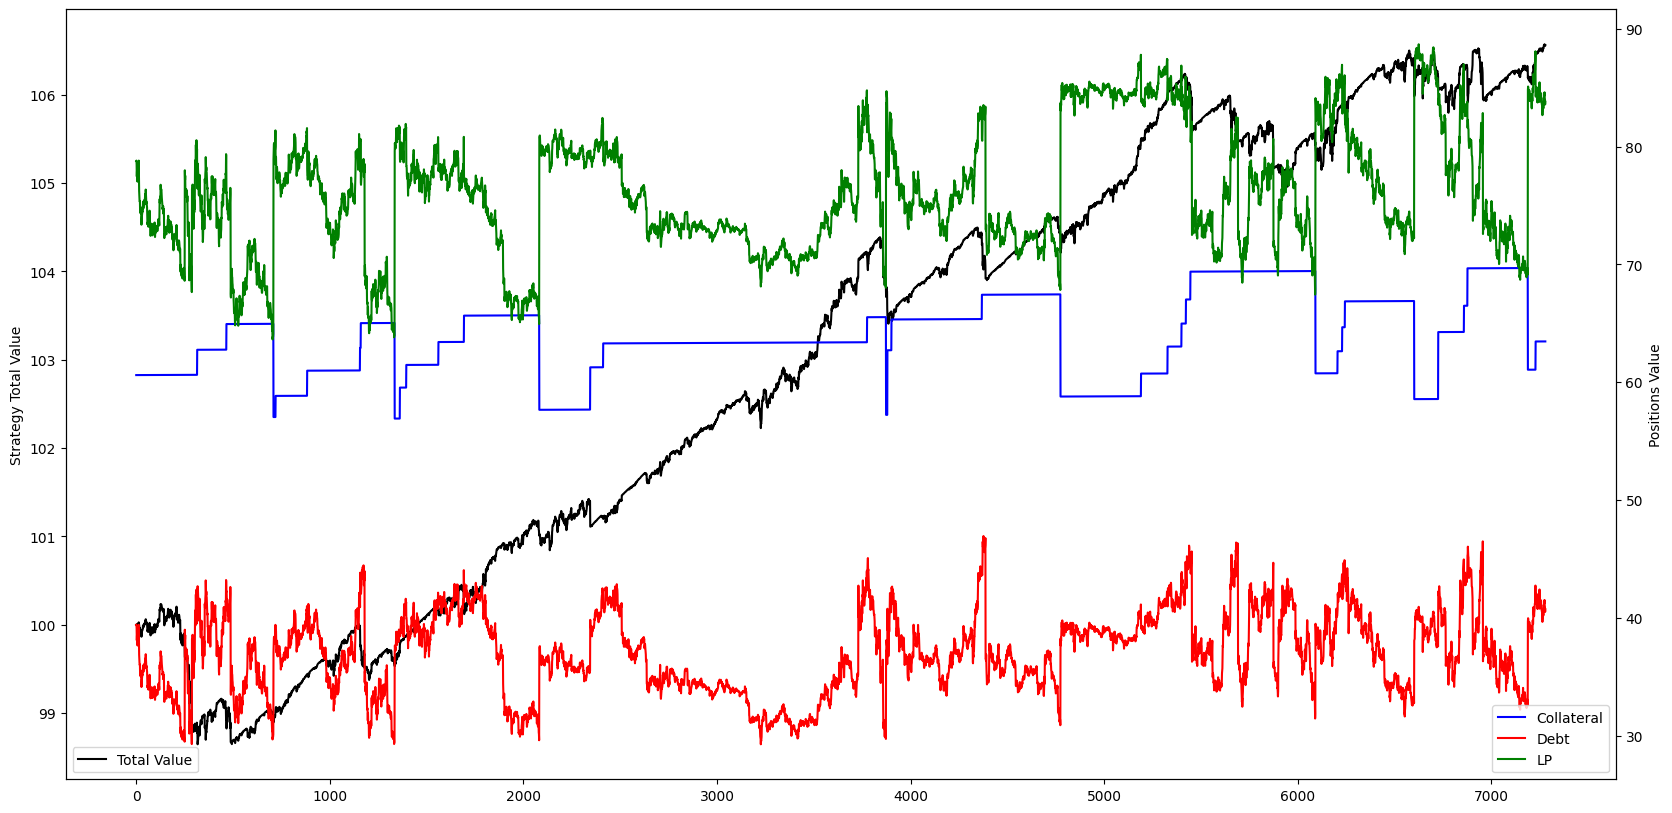

In [5]:
sim.plot_totals(True)

The chart below shows the strategy value and the FTM price. <br>
Rebalancing operations are also shown.

The main point here is the rebalancing operations occur during periods of volatility. Note that during the long period of low volatiltiy there were practically no rebalancing operations and the strategy generated consistent returns. <br>
It's also curious to note that exposure rebalancing operations tend to mark local bottoms on the strategy performance.

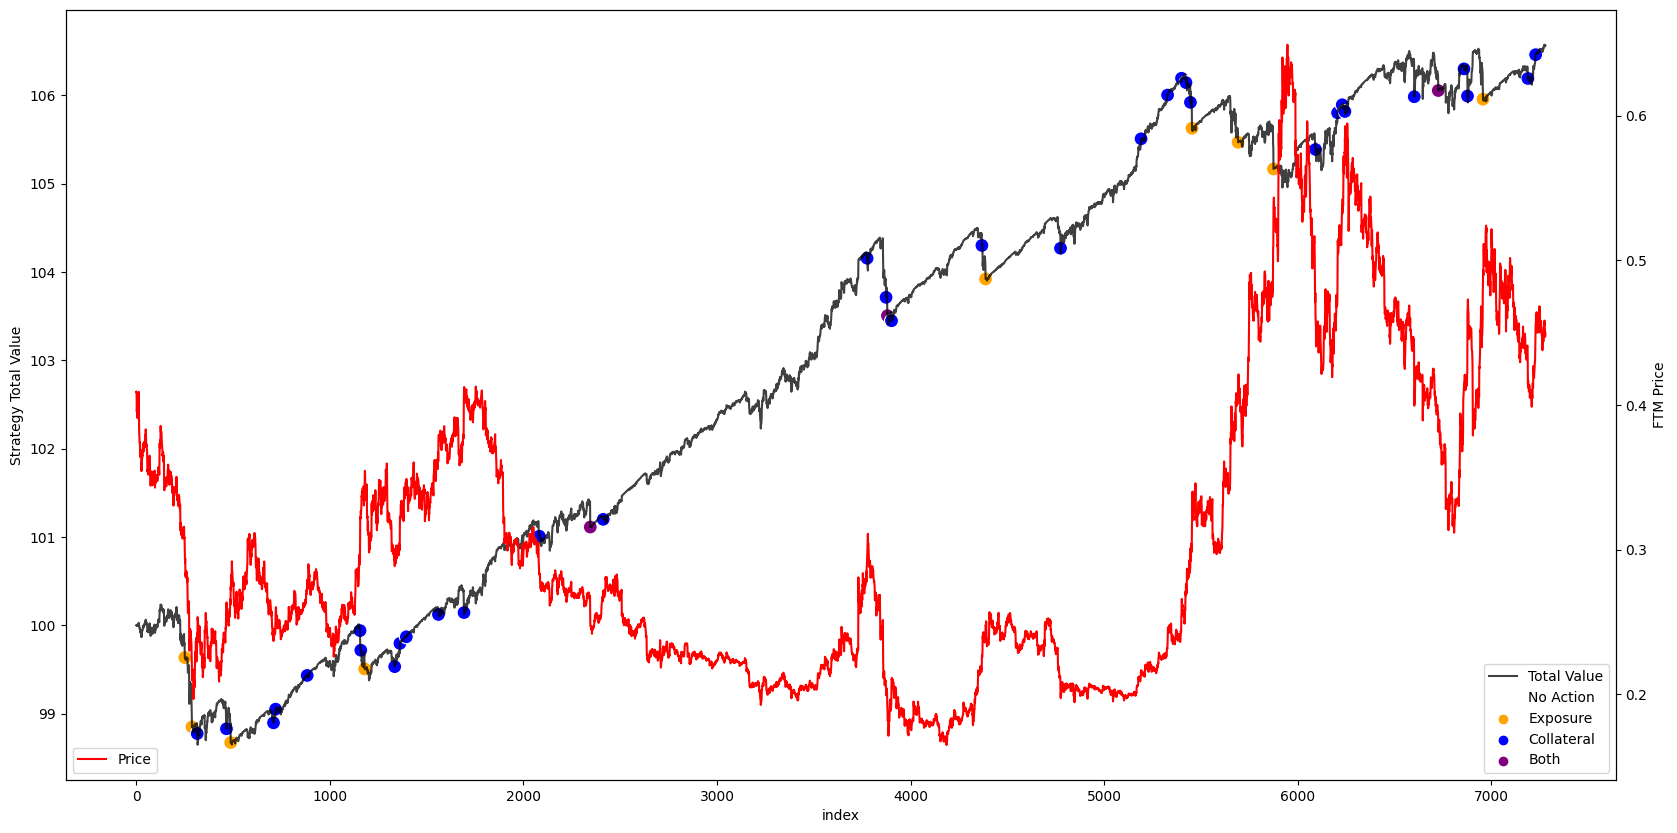

In [6]:
sim.plot_totals_with_rebalance_points()

The chart below is mostly for reference and to demonstrate how the collateral ratio and exposure react during the evolution of the strategy.

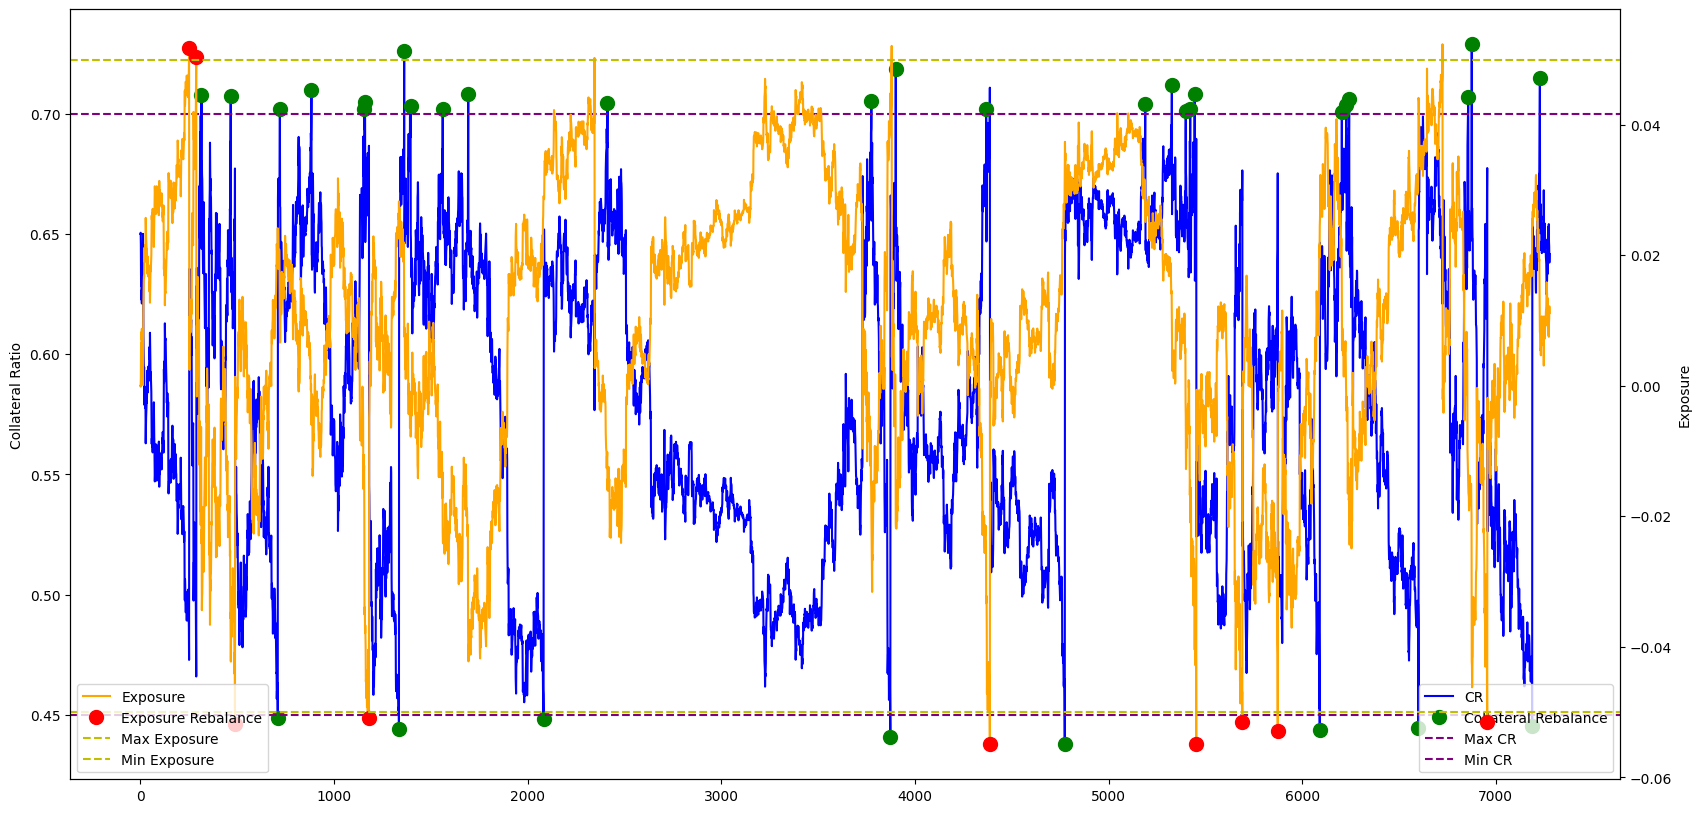

In [8]:
sim.plot_cr_exposure()

#### Sim 2

Our second example has a 10% long exposure and has a tighter exposure rebalancing range of 2.5%.

Notes:
- Even though the stratey is profitable, there is significant more volatility to its returns. This can be seen in the daily and weekly max and min returns
- Note that with a tighter exposure rebalancing range, we rebalance exposure more frequently than collateral

In [21]:
te = 0.1
e_thresh = 0.025
sim = SimulateStrat(t, tcr, te)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $109.03
Strategy Max: $112.31
Strategy Min: $92.65

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 9.028%
Total Return: $9.02818
Annualized Return: 10.865%
Max Daily Return: 2.485%
Min Daily Return: -3.282%
Max Weekly Return: 4.938%
Min Weekly Return: -6.935%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.73
Max Exposure: 0.13
Min Collateral Ratio: 0.41
Min Exposure: 0.07

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 11
Count of Exposure Rebalance: 23
Count of Both Rebalance: 2
Count of Exposure Update: 0


Note that with a relatively high long exposure (10%), the returns of the strategy become significantly more correlated to the price of FTM.

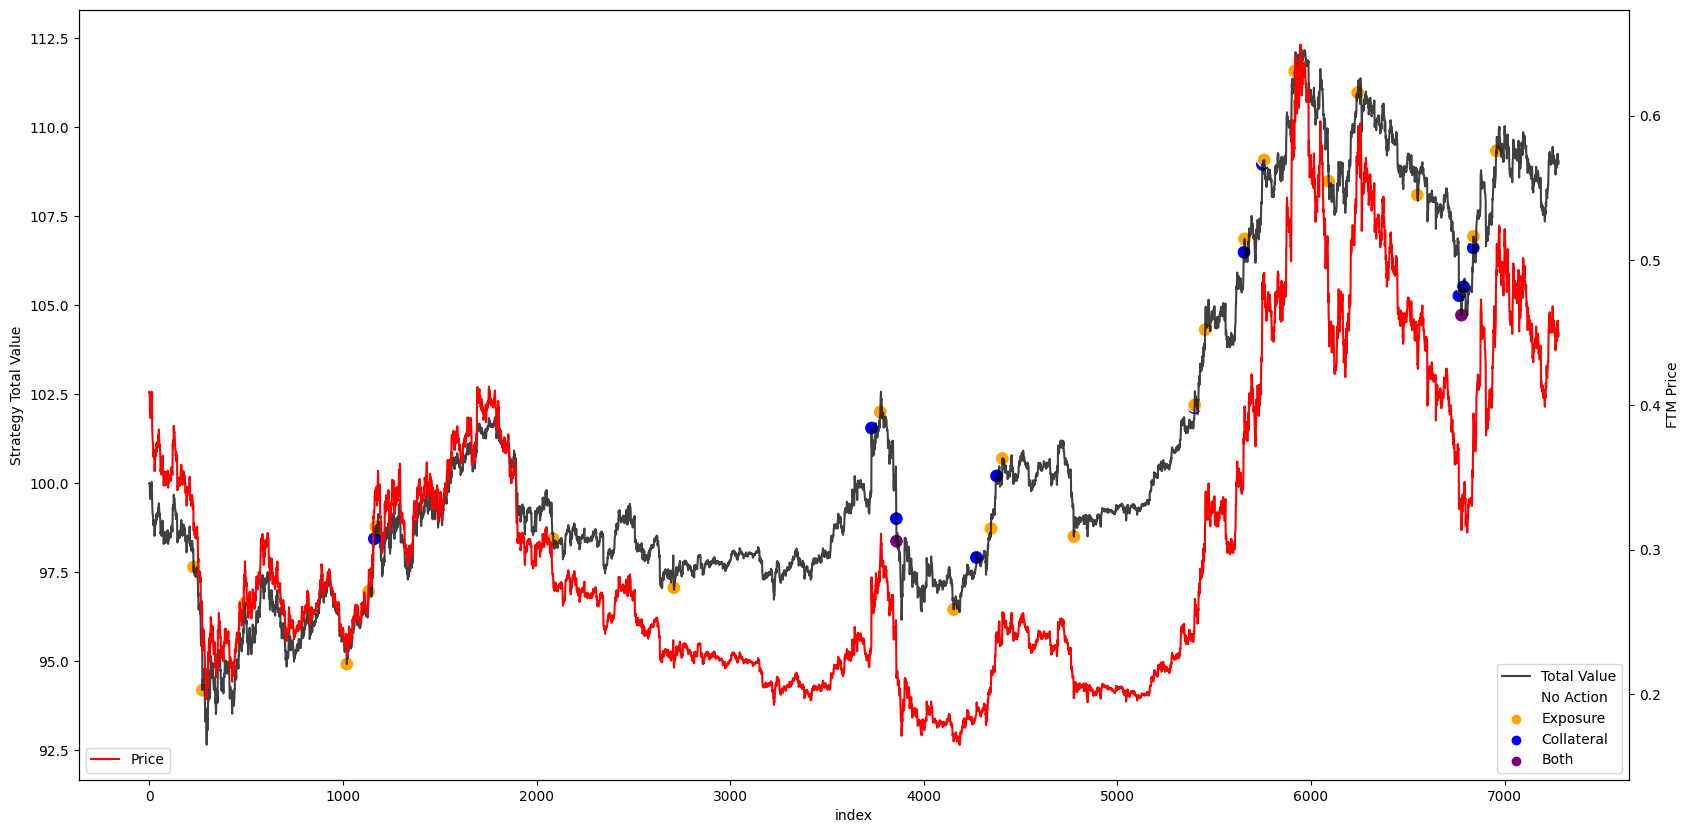

In [22]:
sim.plot_totals_with_rebalance_points()

#### Sim 3

Our third example has a -5% short exposure and has a exposure rebalancing range of 10%.

Notes:
- Even though the strategy has a negative performance, which makes sense given FTM price increase (>300%), the max drawdown was from 102.97 to 92.03 which corresponds to approx. a 10.5% drawdown.
- Also note that with a 10% exposure rebalance threshold, we dont have a single exposure rebalancing operation, and 8 cases where we rebalance both

In [31]:
te = -0.05
e_thresh = 0.1
sim = SimulateStrat(t, tcr, te)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $96.90
Strategy Max: $102.97
Strategy Min: $92.03

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: -3.099%
Total Return: $-3.09878
Annualized Return: -3.729%
Max Daily Return: 1.311%
Min Daily Return: -2.514%
Max Weekly Return: 2.834%
Min Weekly Return: -4.614%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.76
Max Exposure: 0.05
Min Collateral Ratio: 0.44
Min Exposure: -0.16

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 33
Count of Exposure Rebalance: 0
Count of Both Rebalance: 8
Count of Exposure Update: 0


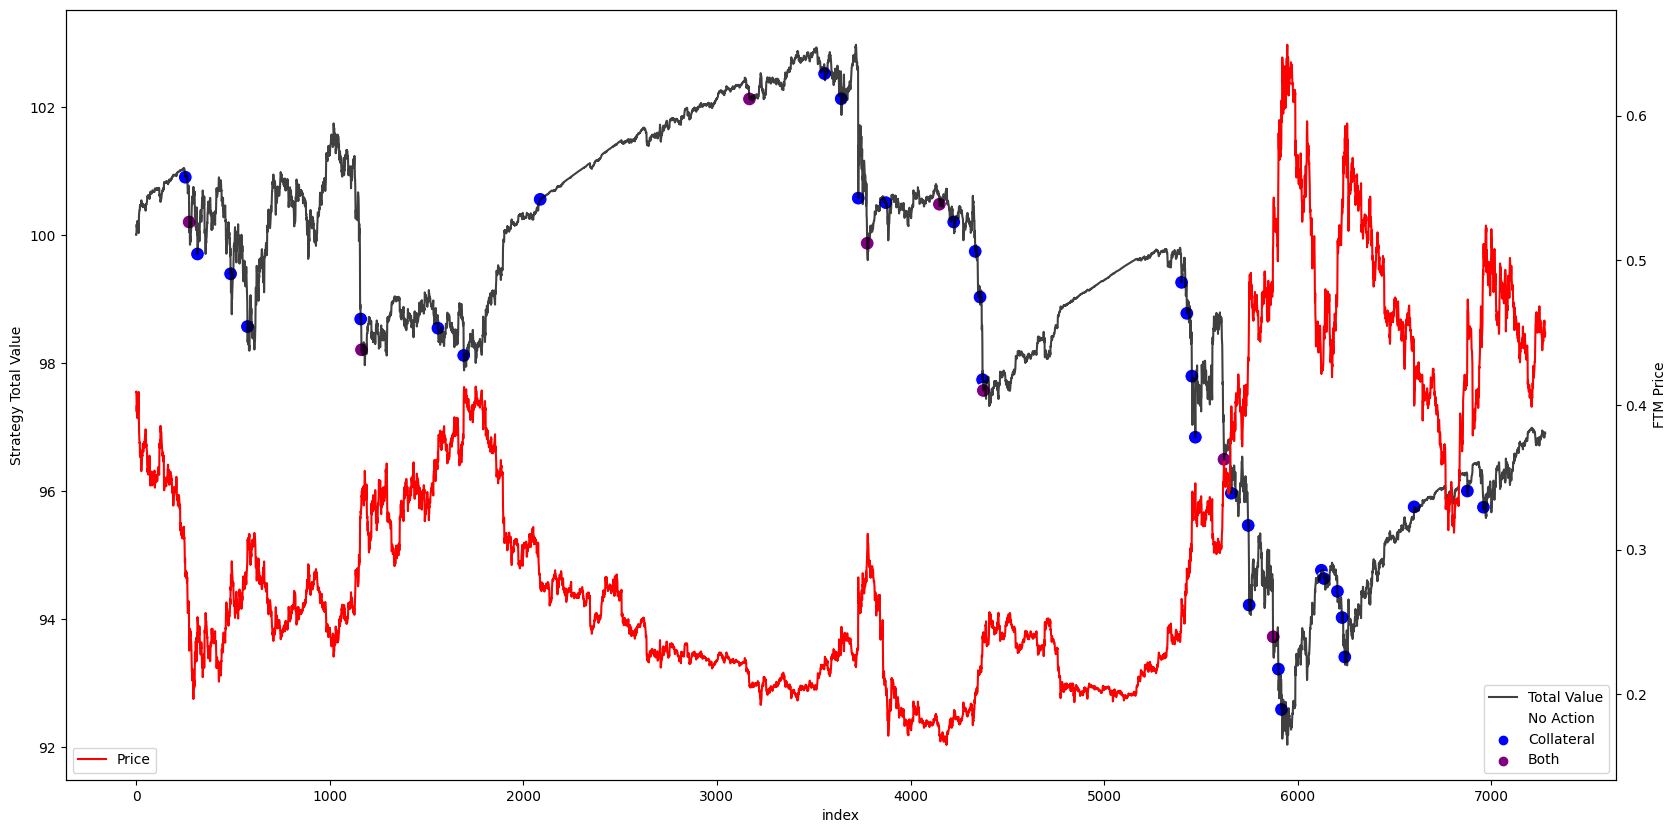

In [32]:
sim.plot_totals_with_rebalance_points()

## Detailed Analysis

Now, that we have defined how the strategy works and given a sense of how the strategy performs given different parameters, we will perform a detailed analysis on our strategy. 

### Paramaters and Price Analisys

We will now analyze how the strategy reacts during different price scenarios given different parameters.

#### Pricefeeds Review

We start by plotting the different pricefeeds.

Below we can see the different price feeds we will be using.
The pricefeeds can be divided into 4 buckets:
- Up
- Down
- Range
- Concave

In [2]:
feeds = pd.read_csv('price_datasets.csv')
for c in feeds.columns:
    total = 100*(feeds[c].values[-1]-feeds[c].values[0])/feeds[c].values[0]
    max_return = 100*(feeds[c].max()-feeds[c].values[0])/feeds[c].values[0]
    max_drawdown = 100*(feeds[c].values[0]-feeds[c].min())/feeds[c].values[0]
    print('Feed: {}\n--------------'.format(c))
    print('Total Return: {0:.2f}% , Max Return: {1:.2f}% , Max Drawdown: -{2:.2f}%\n'.format(total,max_return,max_drawdown))

Feed: up
--------------
Total Return: 120.00% , Max Return: 120.00% , Max Drawdown: -0.00%

Feed: down
--------------
Total Return: -60.00% , Max Return: 0.00% , Max Drawdown: -60.00%

Feed: concave up
--------------
Total Return: 0.00% , Max Return: 0.00% , Max Drawdown: -35.48%

Feed: concave down
--------------
Total Return: 0.00% , Max Return: 57.89% , Max Drawdown: -0.00%

Feed: range
--------------
Total Return: 0.00% , Max Return: 50.00% , Max Drawdown: -50.00%

Feed: big range
--------------
Total Return: 0.00% , Max Return: 100.00% , Max Drawdown: -50.00%

Feed: tight range
--------------
Total Return: -5.00% , Max Return: 25.00% , Max Drawdown: -10.00%

Feed: up range
--------------
Total Return: 80.00% , Max Return: 80.00% , Max Drawdown: -0.00%

Feed: down range
--------------
Total Return: -45.00% , Max Return: 0.00% , Max Drawdown: -45.00%

Feed: big concave up
--------------
Total Return: 0.00% , Max Return: 0.00% , Max Drawdown: -54.55%

Feed: big concave down
---------

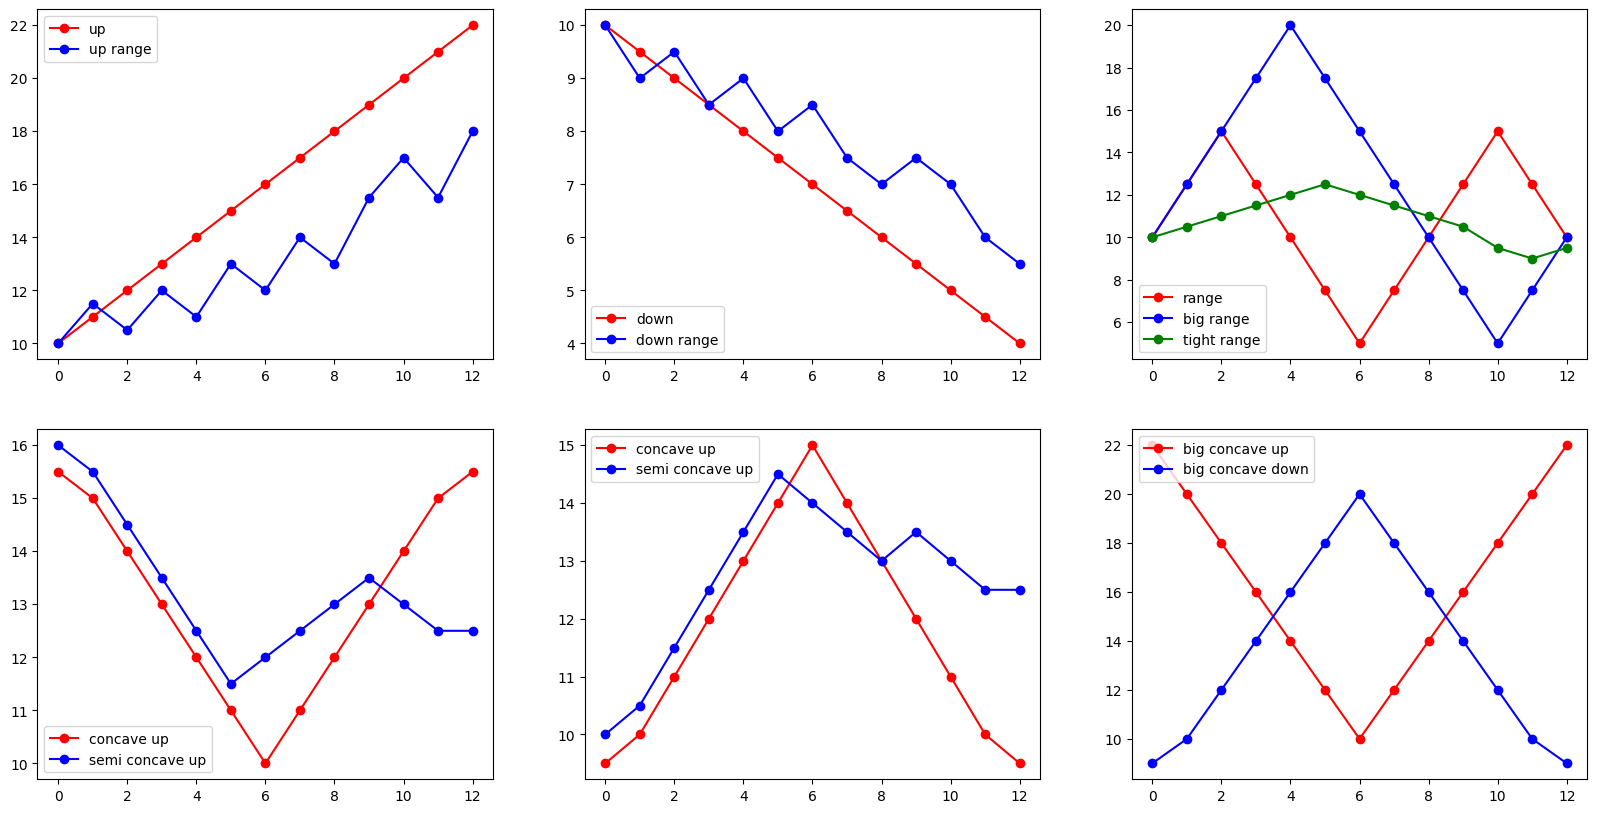

In [3]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20,10)
f_plt = feeds.copy()

ax[0,0].plot(f_plt['up'], marker='o',color='r', label='up')
ax[0,0].plot(f_plt['up range'], marker='o',color='b', label='up range')
ax[0,0].legend(loc='upper left')

ax[0,1].plot(f_plt['down'], marker='o',color='r', label='down')
ax[0,1].plot(f_plt['down range'], marker='o',color='b', label='down range')
ax[0,1].legend(loc='lower left')

ax[0,2].plot(f_plt['range'], marker='o',color='r', label='range')
ax[0,2].plot(f_plt['big range'], marker='o',color='b', label='big range')
ax[0,2].plot(f_plt['tight range'], marker='o',color='green', label='tight range')
ax[0,2].legend(loc='lower left')

ax[1,0].plot(f_plt['concave up'], marker='o',color='r', label='concave up')
ax[1,0].plot(f_plt['semi concave up'], marker='o',color='b', label='semi concave up')
ax[1,0].legend(loc='lower left')

ax[1,1].plot(f_plt['concave down'], marker='o',color='r', label='concave up')
ax[1,1].plot(f_plt['semi concave down'], marker='o',color='b', label='semi concave up')
ax[1,1].legend(loc='upper left')

ax[1,2].plot(f_plt['big concave up'], marker='o',color='r', label='big concave up')
ax[1,2].plot(f_plt['big concave down'], marker='o',color='b', label='big concave down')
ax[1,2].legend(loc='upper left')

plt.show()

#### High-Level Return Analisys

Below, we will be calculating the returns of the strategy for all price feeds given different exposure parameters. <br>
All parameters will remain static except target exposure and exposure thresholds.

In [53]:
# Define a function used to run multiple sims
def run_multiple_sims(sim: SimulateStrat, pricefeed: list[float], c_apr: float, d_apr: float, l_apr: float, min_per_step: float, 
                      max_cr_ls: list[float], e_thresh_ls: list[float], min_cr_ls: list[float], update_exposure: list[float]=[], 
                      names: list[float]=[]):
    t = sim.get_total()
    results = {}
    
    # Loop through sim_params
    for i in range(0, len(max_cr_ls)):
        # reset sim
        sim.reset_strat(t)
        
        # run sim
        max_cr = max_cr_ls[i]
        e_thresh = e_thresh_ls[i]
        min_cr = min_cr_ls[i]
        sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr, update_exposure)
        
        # Get max drawdowns and max returns
        periods_per_day = 24*60/min_per_step
        sim.simdf['daily_return'] = sim.simdf['Total'].pct_change(int(periods_per_day))
        periods_per_week = 7*24*60/min_per_step
        sim.simdf['weekly_return'] = sim.simdf['Total'].pct_change(int(periods_per_week))
        
        # Save sim results
        k = 'max cr: {0} - e thresh: {1} - min cr: {2}'.format(max_cr, e_thresh, min_cr) if len(names)==0 else names[i]
        results[k] = {}
        results[k]['return'] = 100*(sim.t_feed[-1] - sim.t_feed[0])/sim.t_feed[0]
        results[k]['annualized_return'] = np.round(365*((sim.t_feed[-1] - sim.t_feed[0])/(sim.min_per_step*len(sim.pricefeed)/(60*24)))/sim.t_feed[0], 4)
        results[k]['max_cr'] = max(sim.cr_feed)
        results[k]['max_e'] = max(sim.e_feed)
        results[k]['min_cr'] = min(sim.cr_feed)
        results[k]['min_e'] = min(sim.e_feed)  
        results[k]['cr_rebal_count'] = sum([x == 'Collateral' for x in sim.action_feed])
        results[k]['exposure_rebal_count'] = sum([x == 'Exposure' for x in sim.action_feed])
        results[k]['both_rebal_count'] = sum([x == 'Both' for x in sim.action_feed])
        results[k]['exposure_update_count'] = sum([x == 'Updated Exposure' for x in sim.action_feed])
        results[k]['df'] = sim.simdf
        results[k]['params'] = {'max_cr':max_cr, 'e_thresh':e_thresh, 'min_cr':min_cr}
        results[k]['max_daily_return'] = sim.simdf['daily_return'].max()
        results[k]['min_daily_return'] = sim.simdf['daily_return'].min()
        results[k]['max_weekly_return'] = sim.simdf['weekly_return'].max()
        results[k]['min_weekly_return'] = sim.simdf['weekly_return'].min()
        t_feed = sim.simdf['Total']
        results[k]['max_return'] = 100*(t_feed.max()-t_feed.values[0])/t_feed.values[0]
        results[k]['max_drawdown'] = 100*(t_feed.min()-t_feed.values[0])/t_feed.values[0]
        
    return results

In [54]:
# Define sim static params
t = 100
tcr = 0.65
c_apr = 0.01
d_apr = 0.02
l_apr = 0.25
min_per_step = 60
min_cr = 0.45
max_cr = 0.7

# Define hyperparams
e_thresh_ls = [0.01, 0.025, 0.05, 0.1, 0.99]
te_ls = [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]
min_cr_ls = [min_cr]*len(e_thresh_ls)
max_cr_ls = [max_cr]*len(e_thresh_ls)

# Loop through pricefeeds and exposure
sim_results = {}
for f in feeds.columns:
    pricefeed = feeds[f].to_list()    
    for te in te_ls:
        sim = SimulateStrat(t, tcr, te)
        results = run_multiple_sims(sim, pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr_ls, e_thresh_ls, min_cr_ls)
        for k in results.keys():
            k1 = k+' - te: {0} - feed: {1}'.format(te, f)
            sim_results[k1] = results[k]
            sim_results[k1]['params']['te'] = te
            sim_results[k1]['params']['pricefeed'] = f

#Create df to analyze sims
sim_ls = [{**v['params'], 'return': v['return'], 'annualized_return': v['annualized_return'], 
           'cr_rebal_count': v['cr_rebal_count'], 'exposure_rebal_count': v['exposure_rebal_count'],
  'both_rebal_count': v['both_rebal_count'], 'exposure_update_count': v['exposure_update_count'], 
           'max_daily_return': v['max_daily_return'], 'min_daily_return': v['min_daily_return'], 
           'max_weekly_return': v['max_weekly_return'], 'min_weekly_return': v['min_weekly_return'],
          'max_return': v['max_return'], 'max_drawdown': v['max_drawdown']} 
          for v in sim_results.values()]

df = pd.DataFrame(sim_ls)

In [110]:
# Function to display sims data
def display_sims(pricefeeds, df):
    # Melt df
    dfm = df.loc[df['pricefeed'].isin(pricefeeds)].melt(id_vars=['te','pricefeed','e_thresh'], 
                                                               value_vars=['return','max_return','max_drawdown'], 
                                                               var_name='cols', value_name='returns')

    # Print key data
    for p in pricefeeds:
        print('Pricefeed: {}\n'.format(p)+'----------------')
        d = dfm.loc[dfm['pricefeed']==p].reset_index()

        # Get params for max and min total return  
        _id = d.loc[d['cols']=='return', 'returns'].idxmax()
        print('Total Max {:.4f}% -> te: {} , e thresh: {}'.format(d['returns'].values[_id], d['te'].values[_id], 
                                                                   d['e_thresh'].values[_id]))
        _id = d.loc[d['cols']=='return', 'returns'].idxmin()
        print('Total Min {:.4f}% -> te: {} , e thresh: {}'.format(d['returns'].values[_id], d['te'].values[_id], 
                                                                   d['e_thresh'].values[_id]))

        # Get params for max and min max return  
        _id = d.loc[d['cols']=='max_return', 'returns'].idxmax()
        print('Max Return {:.4f}% -> te: {} , e thresh: {}'.format(d['returns'].values[_id], d['te'].values[_id], 
                                                                   d['e_thresh'].values[_id]))

        # Get params for max and min drawdown  
        _id = d.loc[d['cols']=='max_drawdown', 'returns'].idxmin()
        print('Max Drawdown {:.4f}% -> te: {} , e thresh: {}'.format(d['returns'].values[_id], d['te'].values[_id], 
                                                                   d['e_thresh'].values[_id]))    
        print('\n')
    sns.relplot(x='te', y='returns', data=dfm, kind='scatter', col='pricefeed', hue='e_thresh', size='cols', style='cols',
                palette=sns.color_palette("flare", as_cmap=True))
    plt.show()

Pricefeed: range
----------------
Total Max -0.6490% -> te: 0.25 , e thresh: 0.1
Total Min -20.8675% -> te: -0.15 , e thresh: 0.1
Max Return 10.9839% -> te: -0.25 , e thresh: 0.99
Max Drawdown -25.4339% -> te: -0.25 , e thresh: 0.1


Pricefeed: big range
----------------
Total Max -0.2558% -> te: 0.25 , e thresh: 0.05
Total Min -20.0606% -> te: -0.25 , e thresh: 0.1
Max Return 18.2894% -> te: 0.25 , e thresh: 0.01
Max Drawdown -29.9916% -> te: -0.25 , e thresh: 0.99


Pricefeed: tight range
----------------
Total Max 1.3065% -> te: -0.25 , e thresh: 0.99
Total Min -2.0380% -> te: -0.2 , e thresh: 0.1
Max Return 5.6468% -> te: 0.25 , e thresh: 0.01
Max Drawdown -6.6982% -> te: -0.25 , e thresh: 0.99




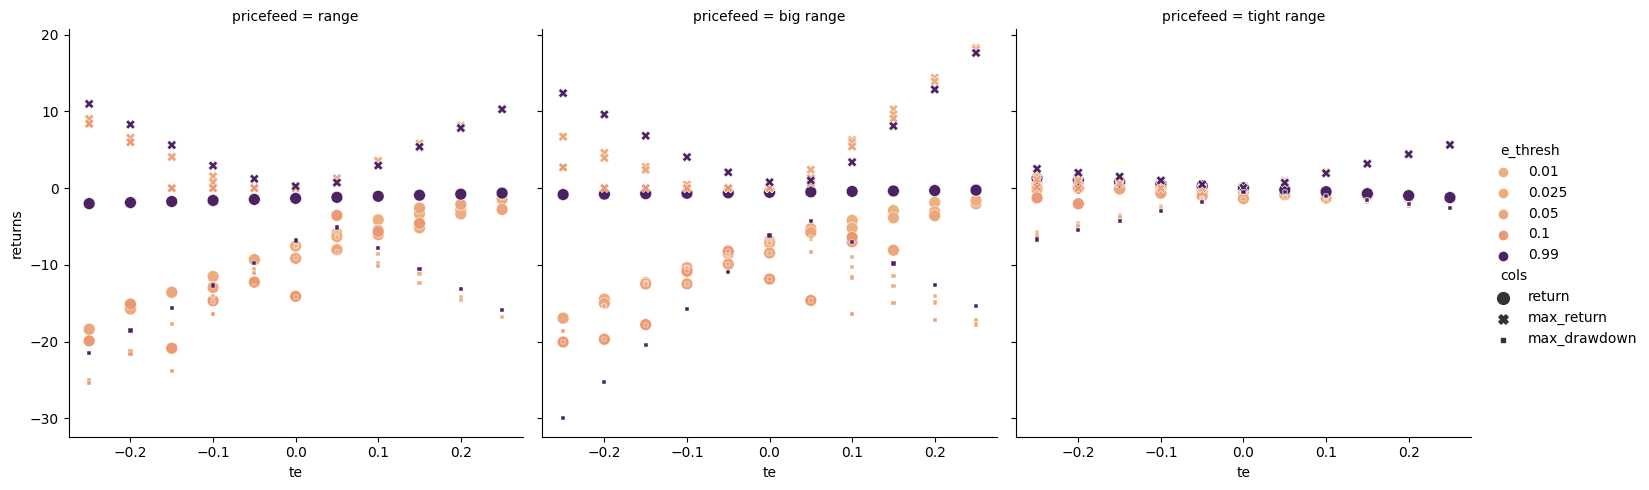

In [111]:
pricefeeds = ['range','big range','tight range']
display_sims(pricefeeds, df)

In [107]:
df

,max_cr,e_thresh,min_cr,te,pricefeed,return,annualized_return,cr_rebal_count,exposure_rebal_count,both_rebal_count,exposure_update_count,max_daily_return,min_daily_return,max_weekly_return,min_weekly_return,max_return,max_drawdown
0,0.7,0.010,0.45,-0.25,up,-19.026865,-128.2118,0,11,1,0,NaN,NaN,NaN,NaN,0.000000,-19.026865
1,0.7,0.025,0.45,-0.25,up,-19.120342,-128.8417,0,10,1,0,NaN,NaN,NaN,NaN,0.000000,-19.120342
2,0.7,0.050,0.45,-0.25,up,-19.940938,-134.3712,0,5,1,0,NaN,NaN,NaN,NaN,0.000000,-19.940938
3,0.7,0.100,0.45,-0.25,up,-21.210902,-142.9288,2,2,2,0,NaN,NaN,NaN,NaN,0.000000,-21.210902
4,0.7,0.990,0.45,-0.25,up,-36.168291,-243.7186,8,0,0,0,NaN,NaN,NaN,NaN,0.000000,-36.168291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0.7,0.010,0.45,0.25,semi concave down,5.561488,37.4759,2,1,0,0,NaN,NaN,NaN,NaN,9.533133,0.000000
711,0.7,0.025,0.45,0.25,semi concave down,5.664027,38.1668,3,0,0,0,NaN,NaN,NaN,NaN,9.436631,0.000000
712,0.7,0.050,0.45,0.25,semi concave down,5.664027,38.1668,3,0,0,0,NaN,NaN,NaN,NaN,9.436631,0.000000
713,0.7,0.100,0.45,0.25,semi concave down,5.664027,38.1668,3,0,0,0,NaN,NaN,NaN,NaN,9.436631,0.000000
